## Autoencoder for anomaly detection - predictive maintenance

In [10]:
# Import necessary dependencies
import requests
import os
import uuid
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import joblib
import h5py
from numpy.random import seed
import tensorflow as tf

from tensorflow.keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

### Load raw data from local CSVs

In [4]:
pdNormal = pd.read_csv('Normal.csv')
pdGradualFailure = pd.read_csv('Gradual.csv')
pdImmediateFailure = pd.read_csv('Immediate.csv')

### Display data for give sensors under different conditions (normal operation, gradual failure, immediate failure)

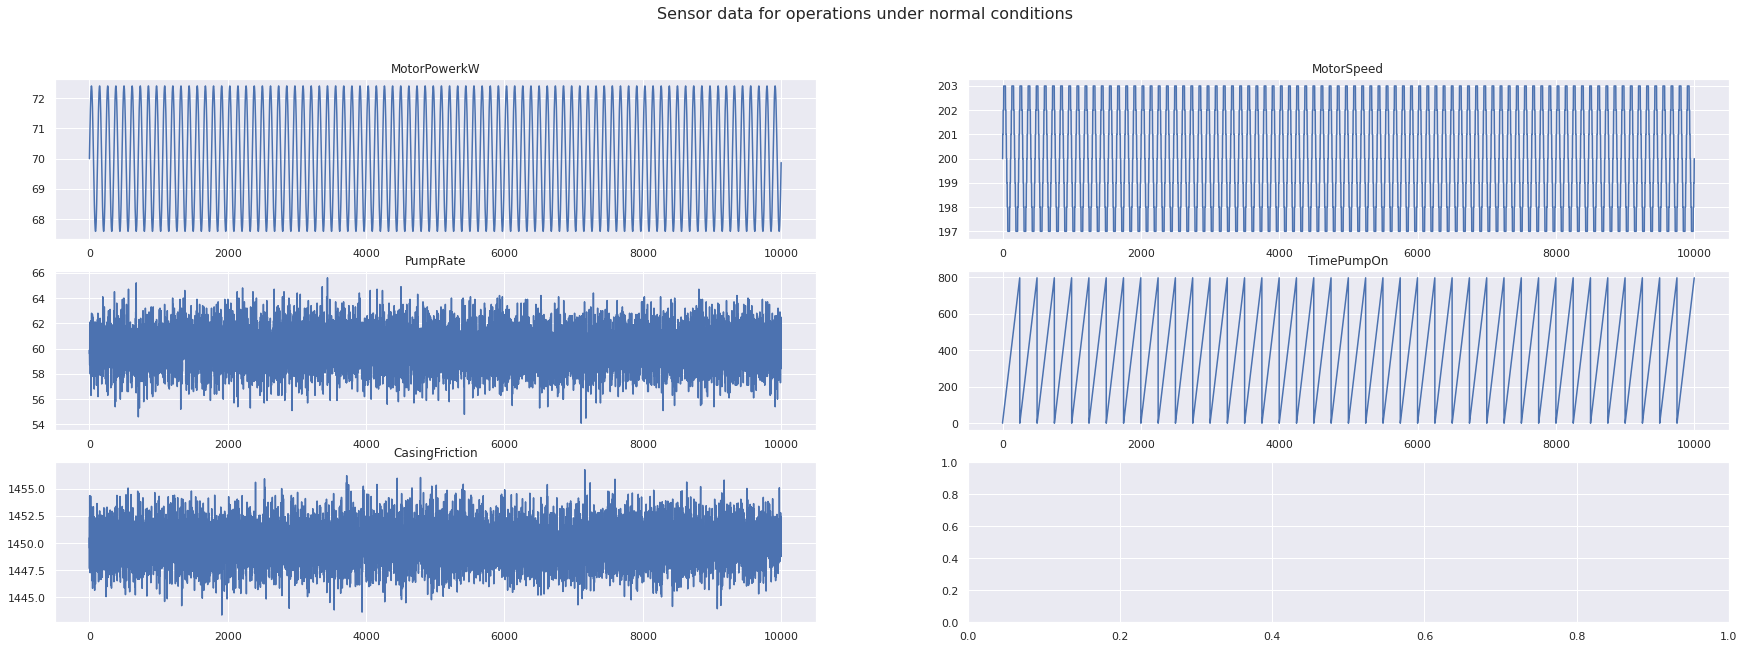

In [12]:
fig, ax = plt.subplots(3,2, figsize=(30,10))

ax[0][0].set_title('MotorPowerkW')
ax[0][1].set_title('MotorSpeed')
ax[1][0].set_title('PumpRate')
ax[1][1].set_title('TimePumpOn')
ax[2][0].set_title('CasingFriction')

ax[0][0].plot(pdNormal['MotorPowerkW'])
ax[0][1].plot(pdNormal['MotorSpeed'])
ax[1][0].plot(pdNormal['PumpRate'])
ax[1][1].plot(pdNormal['TimePumpOn'])
ax[2][0].plot(pdNormal['CasingFriction'])
fig.suptitle('Sensor data for operations under normal conditions', fontsize=16)
display(fig)
plt.close()

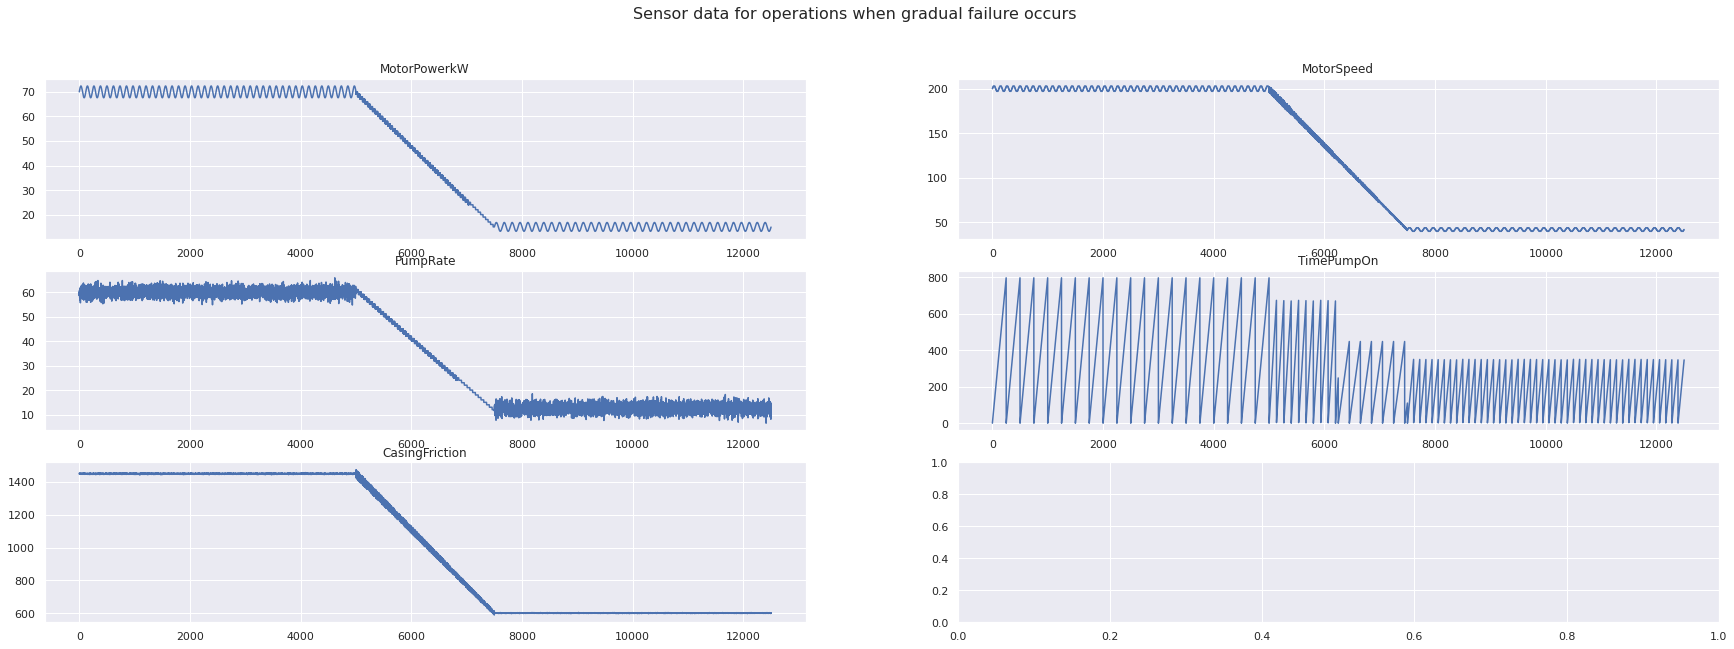

In [13]:
fig, ax = plt.subplots(3,2, figsize=(30,10))

ax[0][0].set_title('MotorPowerkW')
ax[0][1].set_title('MotorSpeed')
ax[1][0].set_title('PumpRate')
ax[1][1].set_title('TimePumpOn')
ax[2][0].set_title('CasingFriction')

ax[0][0].plot(pdGradualFailure['MotorPowerkW'])
ax[0][1].plot(pdGradualFailure['MotorSpeed'])
ax[1][0].plot(pdGradualFailure['PumpRate'])
ax[1][1].plot(pdGradualFailure['TimePumpOn'])
ax[2][0].plot(pdGradualFailure['CasingFriction'])
fig.suptitle('Sensor data for operations when gradual failure occurs', fontsize=16)
display(fig)
plt.close()

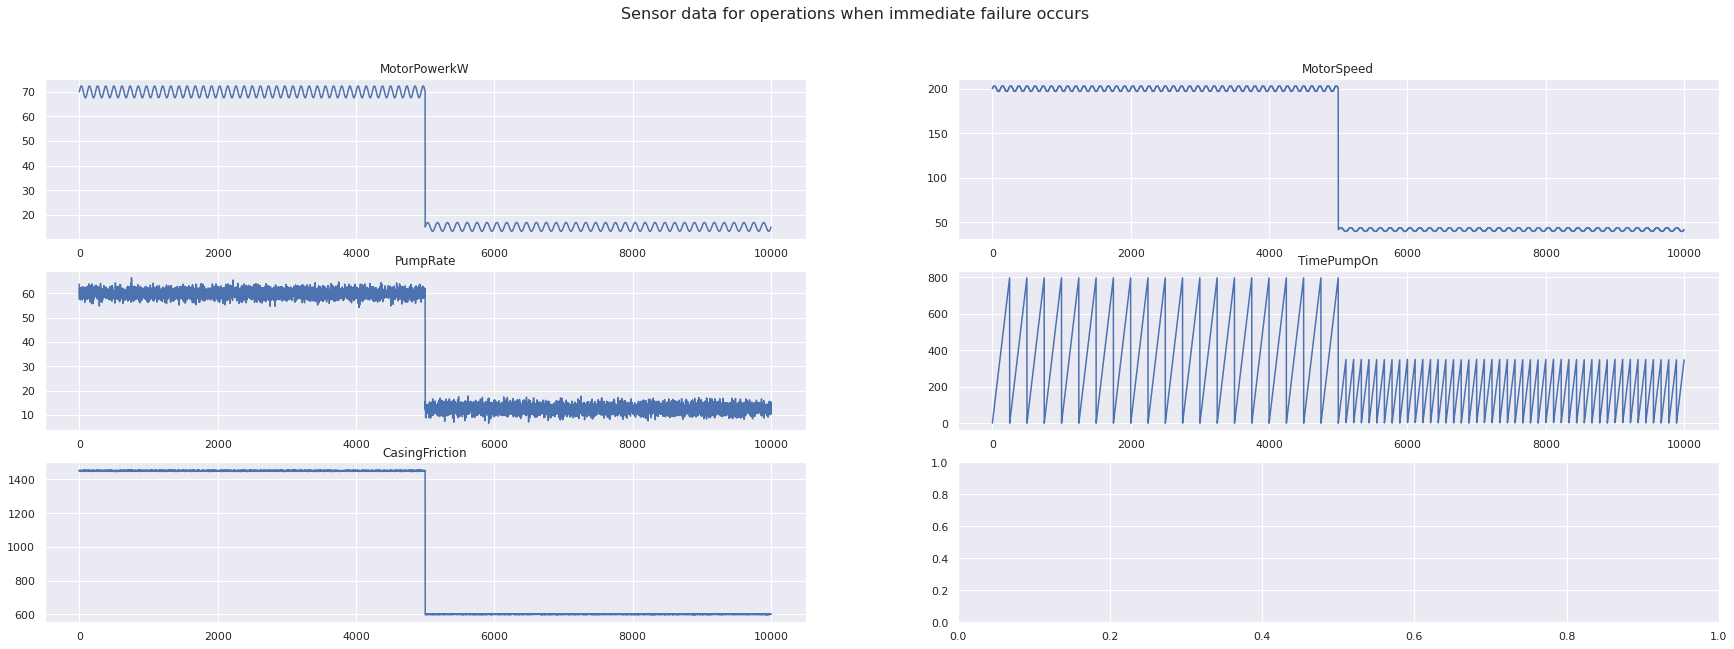

In [14]:
fig, ax = plt.subplots(3,2, figsize=(30,10))

ax[0][0].set_title('MotorPowerkW')
ax[0][1].set_title('MotorSpeed')
ax[1][0].set_title('PumpRate')
ax[1][1].set_title('TimePumpOn')
ax[2][0].set_title('CasingFriction')

ax[0][0].plot(pdImmediateFailure['MotorPowerkW'])
ax[0][1].plot(pdImmediateFailure['MotorSpeed'])
ax[1][0].plot(pdImmediateFailure['PumpRate'])
ax[1][1].plot(pdImmediateFailure['TimePumpOn'])
ax[2][0].plot(pdImmediateFailure['CasingFriction'])
fig.suptitle('Sensor data for operations when immediate failure occurs', fontsize=16)
display(fig)
plt.close()

### Scale all three data sets to ensure all values are properly normalized (MinMax scaler)

In [11]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(pdNormal),
                      columns=pdNormal.columns,
                      index=pdNormal.index)
joblib.dump(scaler, 'scaler.pkl')
X_test1 = pd.DataFrame(scaler.transform(pdGradualFailure),
                      columns=pdGradualFailure.columns,
                      index=pdGradualFailure.index)
X_test2 = pd.DataFrame(scaler.transform(pdImmediateFailure),
                      columns=pdImmediateFailure.columns,
                      index=pdImmediateFailure.index)

### The approach we use for anomaly detection is based on a deep learning model that is trained to recognize normal operating conditions. We are using a special type of deep learning model called an autoencoder. It basically trains to produce outputs that are as similar as possible to the inputs it gets (hence the name autoencoder). As you will see when we actually train the model, we use the same dataset (X_train - sensors under normal conditions) as both training and test data.

### Notice the middle layer of the neural network - the one we named 'feature_vector'. When data reaches this layer it is in the for of a 20-dimensional vector. The layer is very important because this is where we 'split' the trained model. Splitting the trained model here and using this layer as an output means that we have a model that is capable of encoding a combination of five sensor readings into a 20-dimensional vector. This piece of the model is called an encoder (for obvious reasons) and we will use it later to better understand conditions that classify as anomalies.

### Also notice that we are using MSE (Mean Squared Error) as the loss function of the model.

In [8]:
seed(10)
tf.random.set_seed(10)
act_func = 'elu'

input = Input(shape=(X_train.shape[1],))
x = Dense(100,activation=act_func, kernel_initializer='glorot_uniform', kernel_regularizer=regularizers.l2(0.0))(input)
x = Dense(50,activation=act_func, kernel_initializer='glorot_uniform')(x)
encoder = Dense(20,activation=act_func, kernel_initializer='glorot_uniform', name='feature_vector')(x)
x = Dense(50,activation=act_func, kernel_initializer='glorot_uniform')(encoder)
x = Dense(100,activation=act_func, kernel_initializer='glorot_uniform')(x)
output = Dense(X_train.shape[1],activation=act_func, kernel_initializer='glorot_uniform')(x)

model = Model(input, output)
model.compile(loss='mse',optimizer='adam')

encoder_model = Model(inputs=model.input, outputs=model.get_layer('feature_vector').output)
encoder_model.compile(loss='mse',optimizer='adam')

### Train autoencoder model with X_train dataset (normal operating conditions) as both training and test data. For model validation use a 95/5% split.

In [9]:
epochs = 100
batch_size = 10

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=batch_size, 
                  epochs=epochs,
                  validation_split=0.05,
                  verbose = 1)

2021-08-28 18:57:26.712289: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
950/950 [==============================] - 4s 3ms/step - loss: 0.0030 - val_loss: 1.0575e-04
Epoch 2/100
950/950 [==============================] - 3s 3ms/step - loss: 1.1221e-04 - val_loss: 6.0957e-05
Epoch 3/100
950/950 [==============================] - 3s 3ms/step - loss: 8.2254e-05 - val_loss: 1.2711e-04
Epoch 4/100
950/950 [==============================] - 3s 3ms/step - loss: 1.0080e-04 - val_loss: 4.5831e-05
Epoch 5/100
950/950 [==============================] - 2s 2ms/step - loss: 8.3267e-05 - val_loss: 8.3247e-05
Epoch 6/100
950/950 [==============================] - 3s 3ms/step - loss: 8.7842e-05 - val_loss: 3.5886e-05
Epoch 7/100
950/950 [==============================] - 3s 3ms/step - loss: 7.2339e-05 - val_loss: 2.9567e-05
Epoch 8/100
950/950 [==============================] - 2s 3ms/step - loss: 7.0075e-05 - val_loss: 6.1793e-05
Epoch 9/100
950/950 [==============================] - 2s 3ms/step - loss: 7.5712e-05 - val_loss: 4.8797e-05
Epoch 10/100
950/950 [=

### Plot evolution of the loss function (MSE) across advancing of epochs 

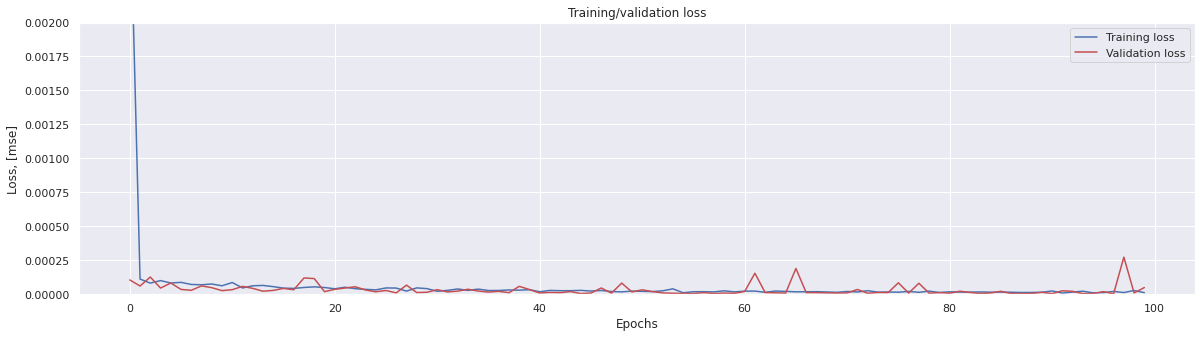

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20,5))

ax.set_title('Training/validation loss')

plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.002])
display(fig)
plt.close()

### Given the trained model, we are using it to make predictions on the same data it trained and then we calculate the loss in the form of MAE (Mean Average Error) between the predicted values and the actual values.

### The histogram representation of this result (MAE loss) enables us to understand what is the reasonable value for the value that identifies 'normal conditions'. Looking at the right end of the bell shape, we can safely assume that 0.01 is a good value for the threshold.

### This result is remarkable! We have found a limit of the loss function that, if exceeded, means we are moving into anomaly territory. We will use this in the next steps to detect anomalies.

/home/nickwiecien/Brunswick/LocalTrainingExample/env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


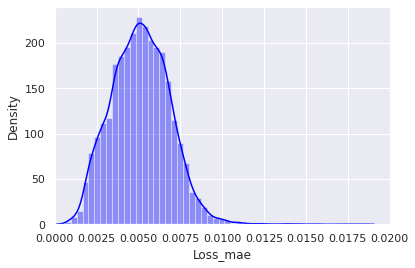

In [16]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

fig, ax = plt.subplots(1,1)
sns.distplot(scored['Loss_mae'],
             bins = 50, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.02])
display(fig)
plt.close()

### Save both models (the full autoencoder as well as its half, the encoder) for future use

In [17]:
model.save('anomaly_detection_full_model.h5')
encoder_model.save('anomaly_detection_encoder_model.h5')

### For here on, we suppose we have a trained model that we use to monitor and detect anomalies in the functioning of the system.

### We are now taking the other two data sets (the one containing gradual failure and the one containing immediate failure) and running them through our full model to get the predicted values. We then compare those predicted values with the input values and calculate for each point in the time series the MAE loss. Finally, we mark each point in the time series as an anomaly or not depending on whether MAE exceeds of not the threshold we determined earlier.

In [18]:
model = load_model('anomaly_detection_full_model.h5')

# Batch scoring for gradual failure
X_pred1 = model.predict(np.array(X_test1))
X_pred1 = pd.DataFrame(X_pred1, 
                      columns=X_test1.columns)
X_pred1.index = X_test1.index

scored1 = pd.DataFrame(index=X_test1.index)
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-X_test1), axis = 1)
scored1['Threshold'] = 0.01
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

# Batch scoring for immediate failure
X_pred2 = model.predict(np.array(X_test2))
X_pred2 = pd.DataFrame(X_pred2, 
                      columns=X_test2.columns)
X_pred2.index = X_test2.index

scored2 = pd.DataFrame(index=X_test2.index)
scored2['Loss_mae'] = np.mean(np.abs(X_pred2-X_test2), axis = 1)
scored2['Threshold'] = 0.01
scored2['Anomaly'] = scored2['Loss_mae'] > scored2['Threshold']

### We are finally ready to plot the results. The blue lines are the actual values of the MAE loss function and the orange line is the threshold we have determined earlier.

### Notice how in the case of the gradual failure data set we are detecting the abnormal state quite early, before it reaches the final failed state. In real life, this is extremely important as it allows an automatic shutdown of the system before major failure occurs.

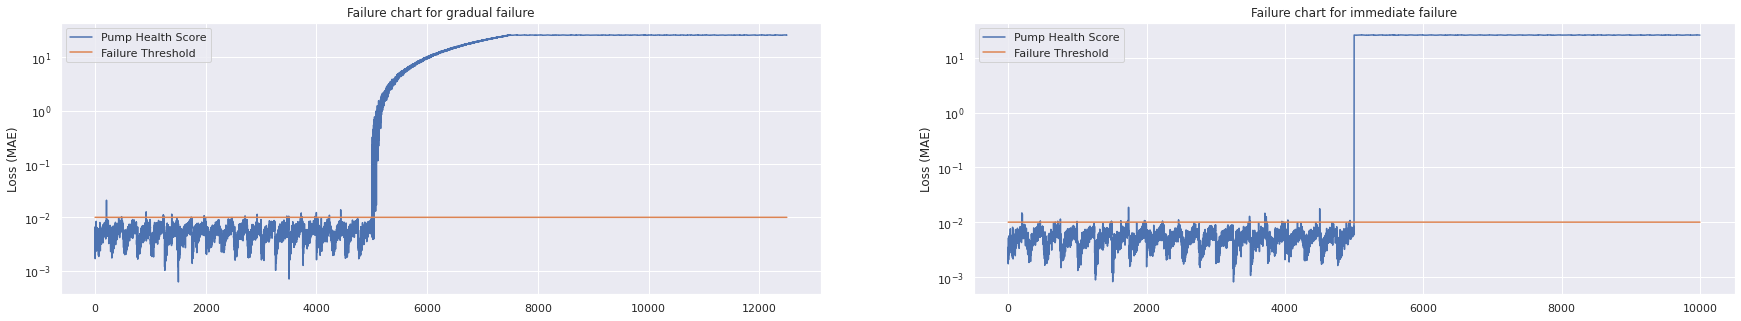

In [19]:
fig, ax = plt.subplots(1,2, figsize=(30,5))

ax[0].set_title('Failure chart for gradual failure')
ax[0].plot(scored1[['Loss_mae', 'Threshold']])

ax[1].set_title('Failure chart for immediate failure')
ax[1].plot(scored2[['Loss_mae', 'Threshold']])

ax[0].set_ylabel('Loss (MAE)')
ax[1].set_ylabel('Loss (MAE)')

ax[0].legend(('Pump Health Score', 'Failure Threshold'), loc='upper left')
ax[1].legend(('Pump Health Score', 'Failure Threshold'), loc='upper left')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

display(fig)
plt.close()

### Save model to disk

In [20]:
import uuid
import os

# Create a temporary folder to store locally relevant content for this notebook
tempFolderName = './SavedModel/autoencoder_{0}'.format(uuid.uuid4())
os.makedirs(tempFolderName, exist_ok=True)
print('Content files will be saved to {0}'.format(tempFolderName))

Content files will be saved to ./SavedModel/autoencoder_d341aa9c-9175-4d96-8295-b703617cb8a2


In [21]:
import os
models_dir = tempFolderName + "/models/"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [22]:
model = load_model('anomaly_detection_full_model.h5')
model.save(models_dir + 'anomaly_score.h5')
scaler = joblib.load('scaler.pkl')
joblib.dump(scaler, models_dir + 'scaler.pkl')

['./SavedModel/autoencoder_d341aa9c-9175-4d96-8295-b703617cb8a2/models/scaler.pkl']

### Test loading the model to validate operation

### All the examples above performed batched predictions. Let's take a look now to an approach for real time scoring. We start with the assumption that we have a previously trained model and scaler.

### We start by loading the models from their persisted state.

### Next, we scale the values of one set of sensor readings and run the scaled values through the anomaly detection model.

### We calculate the MAE value (between the predicted values array and the original readings array).

### Finally, we compare the MAE value with the threshold to decide whether we have a normal or abnormal condition. The example below detects a normal condition

In [25]:
scaler = joblib.load(models_dir + 'scaler.pkl')
model = load_model(models_dir + 'anomaly_score.h5')

# Normal conditions
sensor_readings = np.array([70, 200, 60.6, 0, 1448.17])
scaled_sensor_readings = scaler.transform(sensor_readings.reshape(1,-1))

pred_sensor_readings = model.predict(scaled_sensor_readings)
score = np.mean(np.abs(scaled_sensor_readings - pred_sensor_readings[0]))

if score > 0.01:
  print('WARNING! Abnormal conditions detected')
else:
  print('Everything is ok')

Everything is ok


In [26]:
sensor_readings = np.array([14.23, 41, 14.4, 318.50, 601.95])
scaled_sensor_readings = scaler.transform(sensor_readings.reshape(1,-1))

# Abnormal conditions
pred_sensor_readings = model.predict(scaled_sensor_readings)
score = np.mean(np.abs(scaled_sensor_readings - pred_sensor_readings[0]))

if score > 0.01:
  print('WARNING! Abnormal conditions detected')
else:
  print('Everything is ok')

WARNING! Abnormal conditions detected
